In [1]:
import pandas as pd
import sys
import math
import numpy as np

from matplotlib import pyplot as plt

sys.path.append('../utils')
from Album import *
from Concert import *
from Artist import *
from NumpyEncoder import * 
from utils import *

%load_ext autoreload
%autoreload 2


# Cleaning the collected data from different sources to form one unique Json file

## Clean Album dataset

In [48]:
def treat_json_file(in_path2,in_path3,utils,unique_alb,albums,clean_genres,genres) :
   
    albums_json = None
    if in_path2 is not None :
        with open(in_path2,encoding="utf-8") as f:
            albums_json = json.load(f)      
        df_missing_alb = pd.read_csv(in_path3,sep=',')
    
   
    ranks = df_missing_alb['rank']
    ratings = df_missing_alb['rating']
    years = df_missing_alb['year'] 
    i = 0
  
    for tuple in albums_json:
        result = utils.get_albums_info_from_json(tuple)
     
        if result == None :
            continue
        
        albums_id,album_title,artists,label = result
        if albums_id in unique_alb :
            i += 1
            continue
        else :   
            unique_alb.add(albums_id) 
      
        year = None
        if(str(years[i]) not in 'nan') :   
            year = str(years[i]).split(" ")
            if len(year) == 2 :
                year = year[1]
            elif len(year) == 3: 
                    year = year[2]
            else :
                year = year[0]       

        final_genres = set()    
        for g in genres[ranks[i]-1]: 
            for cg in clean_genres['name'] :
                if g in cg : 
                    final_genres.add(g)    
        if len(final_genres) == 0 :
            final_genres.add(clean_genres['name'][0])    
        album = Album(albums_id,album_title,artists,years[i] if len(str(years[i]))> 0 else None,label,ranks[i],ratings[i],list(final_genres))
        albums.append(album.to_dict())
        i += 1
       
    return albums


In [49]:
def clean_data(charts,clean_genres,in_path1,in_path2=None,in_path3=None,out_path=None) : 

    df = pd.read_csv(in_path1,sep=',')    
    genres = pd.read_csv(charts,sep=";")
    genres = genres['Genres'].apply(lambda x: x.split(",")) 
    genres = genres.apply(lambda x: [j.lower().strip() for j in x ]) 


    alb_title = df['title']
    alb_id = df['album_id']
    art_id = df['artist_id']
    art_name = df['artist_name']
    roles = df['role']
    ratings = df['rating']
    ranks = df['rank']
    years = df['year'] 
    labels = df['label']
    extra = df['extra']
    utils = Utils()

    artists = list()
    albums = list() 
    unique_alb = set()
    current_alb = alb_id[0]

    #Csv file
    for i in range(0,len(alb_id)):

        if current_alb != alb_id[i] : 
            if current_alb in unique_alb :
               current_alb = alb_id[i]
               artists = list()
               continue
            else :   
                unique_alb.add(current_alb) 

            final_genres = set()    
            for g in genres[ranks[i-1]-1] : 
                for cg in clean_genres['name'] :
                    if g in cg : 
                        final_genres.add(g)
            
            if len(final_genres) == 0 :
                final_genres.add(clean_genres['name'][0])  


            album = Album(alb_id[i-1],alb_title[i-1],artists,years[i-1] if len(str(years[i-1]))> 0 else None ,labels[i-1].split(','),ranks[i-1],ratings[i-1], list(final_genres))
            albums.append(album.to_dict())
            current_alb = alb_id[i]
            artists = list()

        clean_roles = utils.clean_role(str(roles[i]),True)    
        if str(0) in str(extra[i]) :
           clean_roles.append("main artist")  
        clean_art_name = utils.clean_artist_name(art_name[i])
        artist = Artist(art_id[i],clean_art_name,clean_roles)
        artists.append(artist.to_dict())
        
    # json file 
    
    if in_path2 is not None :
       albums  = treat_json_file(in_path2,in_path3,utils,unique_alb,albums,clean_genres,genres)

    with open(out_path,"w",encoding='utf-8') as write_file:
            json.dump(albums, write_file, indent=4,cls=NumpyEncoder)     
   

### Jazz album dataset 

In [ ]:
clean_data('../../data/albums/albums_top5000-final.csv','../../data/albums/missing_albums_details.json','../../data/albums/missing_albums_ratings.csv','../../data/albums/album-final.json')

### Classical music dataset

In [50]:
#charts,clean_genres,in_path1,in_path2=None,in_path3=None,out_path=None
clean_genres = pd.read_csv("../../data/classical_genres.csv",sep=",")
clean_genres['name'] = clean_genres['name'].apply(lambda x: x.lower()) 
clean_data("../../data/albums_chart/rym_chart_classical.csv",clean_genres,'../../data/albums/albums_top5000_classical.csv'
           ,'../../data/albums/missing_classical_albums_details.json','../../data/albums/missing_classical_albums_ratings.csv','../../data/albums/album-final-classical.json')

## Clean MJF dataset

In [57]:
def clean_data_mjf(in_path,out_path) : 

    albums_json = None
    with open(in_path,encoding="utf-8") as f:
            albums_json = json.load(f)      
        
    concerts = list() 
    utils = Utils()
 
    for tuple in albums_json['concerts']:
      
        result = utils.get_concert_info_from_json(tuple)
        concert_id,concert_name,artists,concert_date,concert_location = result
        concert = Concert(id=concert_id,name=concert_name,artists=artists,date=concert_date,location= concert_location)
        concerts.append(concert.to_dict())
     
    with open(out_path,"w",encoding='utf-8') as write_file:
        json.dump(concerts, write_file, indent=4,cls=NumpyEncoder)  


In [58]:
clean_data_mjf("../../data/mjf/mfj_export.json","../../data/mjf/mfj_export_clean.json")

# General informations on dataset

# Album dataset 

In [10]:
def get_dataset_info(filename) :
    albums_json = None
    with open(filename,encoding="utf-8") as f:
            albums_json = json.load(f)    
    unique_artist = set()
    for i in albums_json : 
    
        for art in i['artists']:
                if art['id'] not in unique_artist:
                    unique_artist.add(art['id'])
    print("Nb albums:",len(albums_json))            
    print("Nb artists:",len(unique_artist))
    max = -np.inf
    min = np.inf
    for i in albums_json : 
        if i['year'] == None :
            continue
        year = i['year']
        if max < int(year) :
            max = int(year)
        if min > int(year) :
            min = int(year)
    print("Min date:",min)
    print("Max date:",max)        

### Jazz album dataset 

In [47]:
get_dataset_info("../../data/albums/album-final.json")

Nb albums: 4741
Nb artists: 23235
Min date: 1939
Max date: 2023


### Classic music Album dataset

In [52]:
get_dataset_info("../../data/albums/album-final-classical.json")

Nb albums: 3668
Nb artists: 25132
Min date: 0
Max date: 2023


### Completeness

In [65]:
genres = 0
nb_no_art = 0
nb_no_role = 0
nb_no_label = 0
for i in albums_json : 
    if len(i['artists']) == 0 :
          nb_no_art+=1
    if i['genres'] == None or len(i['genres']) == 0 :
            genres += 1
    if len(i['labels']) == 0 :  
          nb_no_label+=1
    for art in i['artists'] :
          if art['role'][0] == "" or  art['role'][0] == "nan" :
                nb_no_role+=1

print("Nb no genre:",genres)      
print("Nb no artist:",nb_no_art)       
print("Nb no role:",nb_no_role)      
print("Nb no label:",nb_no_label)  
    

Nb no genre: 0
Nb no artist: 0
Nb no role: 1220
Nb no label: 0


### year repartition 

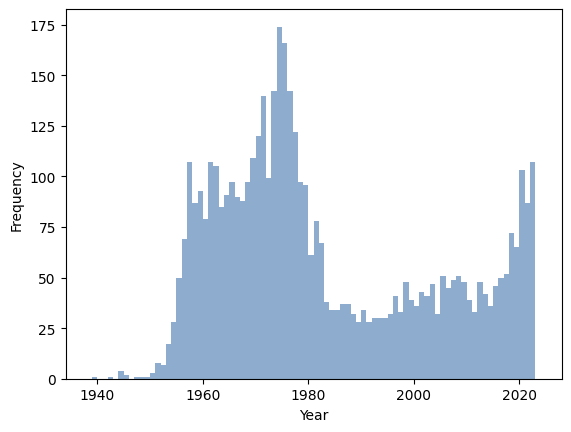

In [49]:

years = list()
for alb in albums_json : 
    if alb['year'] != None :
        years.append(int(alb['year']))


nbins = np.max(years) - np.min(years)

plt.xlim([np.min(years)-5, np.max(years)+5])
plt.hist(years, bins=nbins, alpha=1, color="#8EACCD")
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig("../../data/repartition/album_year_repartition.png",format="png")
plt.show()   

# MJF dataset

In [59]:
mjf_json = None
with open("../../data/mjf/mfj_export_clean.json",encoding="utf-8") as f:
            mjf_json = json.load(f)      

In [62]:
max = -np.inf
min = np.inf
unique_musician = set()
instruments = set()
nb_concerts = 0
nb_no_instrument = 0
nb_no_date = 0
nb_all_musi = 0
for concert in mjf_json :
    
    if len(concert['musicians'] ) == 0:  
        continue

    nb_concerts += 1
    nb_all_musi += len(concert['musicians'] )
    for art in concert['musicians'] :
        if len(art['role']) == 0 : 
            nb_no_instrument += 1 

        for inst in art['role']:
            if inst not in instruments :
                instruments.add(inst)
      
        if art['id'] not in unique_musician :
            unique_musician.add(art['id'])

      
    if len(concert['musicians'] ) == 0:
        continue
    if concert['date'] == None or concert['date'] == "":
        nb_no_date +=1
        continue
    year = concert['date'].split("-")[0]
    if max < int(year) :
        max = int(year)
    if min > int(year) :
        min = int(year)

print("Nb musicians:",len(unique_musician) )       
print("Nb concerts:",nb_concerts )     
print("Nb of roles",len(instruments))
print("Min date:",min)
print("Max date:",max)
print("-------------------------")
print("Nb no instrument:",nb_no_instrument)
print("Nb no date:",nb_no_date)


Nb musicians: 17639
Nb concerts: 4280
Nb of roles 256
Min date: 1967
Max date: 2023
-------------------------
Nb no instrument: 0
Nb no date: 0


In [66]:
utils = Utils()
instr = utils.clean_role(','.join(list(instruments)),is_alb_data=False)

In [ ]:
instr

In [65]:
len(instr)

256

### Concert year repartition

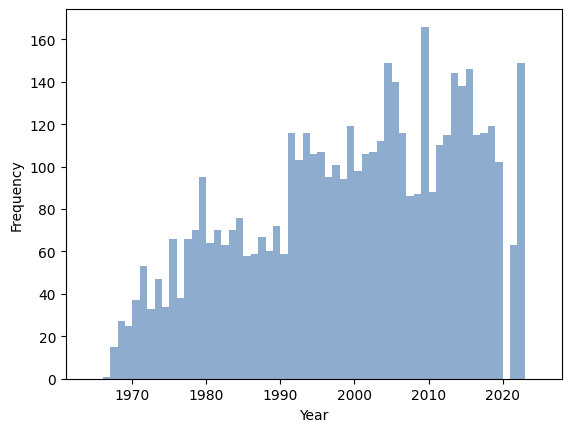

In [50]:

years = list()
for concert in mjf_json['concerts'] : 
    if concert['date']  != None :
        years.append(int(concert['date'].split("-")[0] ))

nbins = np.max(years) - np.min(years)

plt.xlim([np.min(years)-5, np.max(years)+5])
plt.hist(years, bins=nbins, alpha=1,color='#8EACCD')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.savefig("../../data/repartition/mjf_year_repartition.png",format="png")
plt.show()   

In [61]:
import requests
from bs4 import BeautifulSoup

def get_jazz_genres(url):
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'html.parser')

    # Finding all <td> elements with <a> tags
    li_elements = soup.find_all('li')
    
    # Extracting the text content of each <a> tag
    genres = [li.find('a').text.strip() for li in li_elements if li.find('a', {'title': True},{'href': True})]

    return genres

if __name__ == "__main__":
    wikipedia_url = "https://en.wikipedia.org/wiki/List_of_classical_music_genres"
    jazz_genres = get_jazz_genres(wikipedia_url)

    # Printing the list of jazz genres
    for index, genre in enumerate(jazz_genres, start=1):
        print(genre)

Main page
Contents
Current events
Random article
About Wikipedia
Contact us
Donate
Help
Learn to edit
Community portal
Recent changes
Upload file
Create account
Log in
Create account
Log in
Contributions
Talk
Bosanski
Eesti
Español
Français
Македонски
Slovenščina
Српски / srpski
Srpskohrvatski / српскохрватски
中文
Article
Talk
Edit
View history
Edit
What links here
Related changes
Upload file
Special pages
Permanent link
Page information
Cite this page
Wikidata item
Download as PDF
Printable version
Ballade
Ballata
Canso
Conductus
Estampie
Geisslerlied
Gregorian Chant
Lai (poetic form)
Lauda (song)
Madrigal (Trecento)
Motet
Organum
Planctus
Saltarello
Ballade
Canzona
Carol
Chanson
Fantasia
Chromatic fantasia
Galliard
Intermedio
Lauda
Litany
Madrigal
Madrigal comedy
Madrigale spirituale
Mass
Cyclic mass
Parody mass
Paraphrase mass
Cantus firmus mass
Motet
Motet-chanson
Opera
Pavane
Ricercar
Sequence
Tiento
Toccata
Allemande
Bourrée
Canary
Canon
Cantata
Chaconne
Concerto
Concerto grosso
S